In [1]:
import matplotlib.pyplot as plt
from scipy import stats
import scikit_posthocs as sp
import pandas as pd
import numpy as np
from matplotlib import cm
import io
import seaborn as sns
import os
from unidecode import unidecode
from os import listdir
from os.path import isfile, join
import colorcet as cc
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

In [2]:
def read_query_Files(path, join="median", max_rep=3, removeRandom=True):
    subfoldersIndex = [f.path for f in os.scandir(path) if f.is_dir() and ("vp_old" not in f.path)]
    pivos = ["BPP", "CONVEX", "GNAT", "SSS", "MAXSEPARATED", "MAXVARIANCE", "PCA", "IS", "HFI", "WDR", "SELECTION", "KMEDOIDS", "RANDOM"]
    repList = list(range(max_rep))
    df = pd.DataFrame(columns=["Índice", "Pivô", "K", "Tempo", "Cálculos_de_distância", "Acessos_ao_disco"])
    for indexPath in subfoldersIndex:
        files = [f for f in os.scandir(indexPath) if (f.is_file()) and ("stats" not in f.path) and (any([str(rep) in f.path for rep in repList]))]
        for pvt in pivos:
            pivo_files = [f for f in files if pvt in f.path]
            pvtDF = pd.DataFrame()
            index = str()
            pivot = str()
            for f in pivo_files:
                file = open(f)
                line = file.readline().rstrip().split(",")
                index = line[0]
                pivot = line[2]
                dfAux = pd.read_csv(f, sep=',', skiprows=1, header=0)
                pvtDF = pd.concat([pvtDF, dfAux])
            
            if len(pvtDF) != 0:
                pvtDF["index"] = index
                pvtDF["pivot"] = pivot
                if join == "median":
                    pvtDF = pvtDF.groupby(["index", "pivot", "k"])[["time", "count", "disk"]].median().reset_index()
                else:
                    pvtDF = pvtDF.groupby(["index", "pivot", "k"])[["time", "count", "disk"]].mean().reset_index()
                pvtDF = pvtDF[["index", "pivot", "k", "time", "count", "disk"]]
                pvtDF.columns = ["Índice", "Pivô", "K", "Tempo", "Cálculos_de_distância", "Acessos_ao_disco"]
                df = pd.concat([df, pvtDF])

    if removeRandom:
        df = df[df["Pivô"] != "RANDOM"]
    
    indexOrder = ["VPTREE", "MVPTREE", "OMNIKDTREE", "PMTREE", "SPBTREE"]
    df2 = pd.DataFrame(columns=df.columns)
        
    for index in indexOrder:
        dfAux = df[df["Índice"] == index]
        df2 = pd.concat([df2, dfAux])

    df2["Tempo"] = df2["Tempo"]/1e9
        
    return df2

def read_data(path, listDatasets = ['cities', 'card', 'avila'], 
              listIndex = ['VPTREE', 'MVPTREE', 'OMNIKDTREE', 'PMTREE', 'SPBTREE'], 
              by='Cálculos_de_distância', join = "median", max_rep = 3, removeRandom = True,
              outputPath="./", outputName = 'plan', K = 25, _header=True, _index=False):
    
    vp_data = pd.DataFrame()
    mvp_data = pd.DataFrame()
    omni_data = pd.DataFrame()
    pm_data = pd.DataFrame()
    spb_data = pd.DataFrame()
    
    for dataset in listDatasets:
        df = read_query_Files(os.path.join(path, dataset), join=join, max_rep=max_rep, removeRandom=removeRandom)
        for idx in listIndex:
            aux = df[(df['Índice'] == idx) & (df['K'] == K)][['Pivô', by]]
            aux.set_index(['Pivô'], inplace=True)
            aux.columns = [dataset]
            
            if idx == 'VPTREE':
                vp_data = pd.concat([vp_data, aux], axis='columns')
            elif idx == 'MVPTREE':
                mvp_data = pd.concat([mvp_data, aux], axis='columns')
            elif idx == 'OMNIKDTREE':
                omni_data = pd.concat([omni_data, aux], axis='columns')
            elif idx == 'PMTREE':
                pm_data = pd.concat([pm_data, aux], axis='columns')
            elif idx == 'SPBTREE':
                spb_data = pd.concat([spb_data, aux], axis='columns')
            else:
                raise Exception("Unkwon index")
    
    if not vp_data.empty:
        name = 'plan.csv'
        if outputPath[-1] == '/':
            name = outputPath + outputName + "_vp_" + unidecode(by) + ".csv"
        else:
            name = outputPath + '/' + outputName + "_vp_" + unidecode(by) + ".csv"
        vp_data.to_csv(name, index=_index, header=_header)

    if not mvp_data.empty:
        name = 'plan.csv'
        if outputPath[-1] == '/':
            name = outputPath + outputName + "_mvp_" + unidecode(by) + ".csv"
        else:
            name = outputPath + '/' + outputName + "_mvp_" + unidecode(by) + ".csv"
        mvp_data.to_csv(name, index=_index, header=_header)

    if not omni_data.empty:
        name = 'plan.csv'
        if outputPath[-1] == '/':
            name = outputPath + outputName + "_omni_" + unidecode(by) + ".csv"
        else:
            name = outputPath + '/' + outputName + "_omni_" + unidecode(by) + ".csv"
        omni_data.to_csv(name, index=_index, header=_header)
    
    if not pm_data.empty:
        name = 'plan.csv'
        if outputPath[-1] == '/':
            name = outputPath + outputName + "_pm_" + unidecode(by) + ".csv"
        else:
            name = outputPath + '/' + outputName + "_pm_" + unidecode(by) + ".csv"
        pm_data.to_csv(name, index=_index, header=_header)
    
    if not spb_data.empty:
        name = 'plan.csv'
        if outputPath[-1] == '/':
            name = outputPath + outputName + "_spb_" + unidecode(by) + ".csv"
        else:
            name = outputPath + '/' + outputName + "_spb_" + unidecode(by) + ".csv"
        spb_data.to_csv(name, index=_index, header=_header)
    

In [3]:
read_data(path='../../../../../tcc_expt/consultas/', 
          listDatasets = ['cities', 'avila', 'internet', 'card', 'ulcer', 'nasa', 'aloi', 'la', 'sift', 'mnist_s', 'cophir'], 
          listIndex = ['VPTREE', 'MVPTREE', 'OMNIKDTREE', 'PMTREE', 'SPBTREE'], 
          by='Cálculos_de_distância', join = "mean", max_rep = 1, removeRandom = True,
          outputPath="./", outputName = 'plan', K = 25, _header=True, _index=True)

In [4]:
def friedman(path):
    df = pd.read_csv(path, index_col='Pivô')
    df = df.T
    df.index.name = 'Datasets'
    list_data = df.values.tolist()
    print(stats.friedmanchisquare(*list_data))
    
def nemenyi(path, outputPath="./", outputName = 'p_values', _index = True, _header = True):
    df = pd.read_csv(path, index_col='Pivô')
    df.index.name = 'Datasets'
    index = df.index.values.tolist()
    list_data = np.array(df.values.tolist()) 
    p_values = sp.posthoc_nemenyi_friedman(list_data.T)
    
    #print(p_values)
    
    p_values.columns = index
    p_values.index = index
    p_values.index.name = 'Pivô'
    
    if outputPath[-1] == '/':
        p_values.to_csv(outputPath + 'p_values_' + outputName + '.csv', index = _index, header = _header)
    else:
        p_values.to_csv(outputPath + '/' + 'p_values_' + outputName + '.csv', index = _index, header = _header)


In [5]:
friedman('./plan_pm_Calculos_de_distancia.csv')

FriedmanchisquareResult(statistic=113.40909090909088, pvalue=1.0938503722570902e-19)


In [12]:
nemenyi('./plan_spb_Calculos_de_distancia.csv',
        outputPath="./", outputName = 'spb', _index = True, _header = True)

In [8]:
def heatmap_p_value(input_friedman, input_p_values, outputPath = './', outputName = 'heatmap'):
    df = pd.read_csv(input_friedman, index_col='Pivô')
    num_pvt = 12
    df.index = list(range(num_pvt))
    n = len(df)//2 # 5
    weights = [[0 for _ in range(num_pvt)] for _ in range(num_pvt)]
    
    for i in range(num_pvt):
        for j in range(num_pvt):
            if i == j:
                weights[i][i] = 1.0
            else:
                v1 = df.iloc[i, :].values
                v2 = df.iloc[j, :].values
                cnt = 0
                for k in range(len(v1)):
                    if v1[k] < v2[k]:
                        cnt += 1
                if cnt > n:
                    weights[i][j] = 1.0
                    weights[j][i] = -1.0
                else:
                    weights[i][j] = -1.0
                    weights[j][i] = 1.0
                    
    p_values = f = pd.read_csv(input_p_values, index_col='Pivô')
    
    for i in range(num_pvt):
        for j in range(num_pvt):
            if i == j:
                p_values.iloc[i,j] = 1.0
            else:
                if weights[i][j] == -1.0:
                    p_values.iloc[i,j] = p_values.iloc[i,j] + 1.0                    
                
                #p_values.iloc[i,j] = p_values.iloc[i,j] * weights[i][j]
    
#     p_values.iloc[0,0] = -1.0
#    p_values.iloc[11,11] = 1.0
    
    g = sns.heatmap(p_values, annot=True, annot_kws={"size": 7}, cmap="rocket_r")
    
    if outputPath == None:
        return g
    elif outputPath[-1] == '/':
        plt.savefig(outputPath + "heatmap_p_values_" + outputName + ".svg", dpi = 300)
    else:
        plt.savefig(outputPath + "/" + "heatmap_p_values_" + outputName + ".svg", dpi = 300)
    

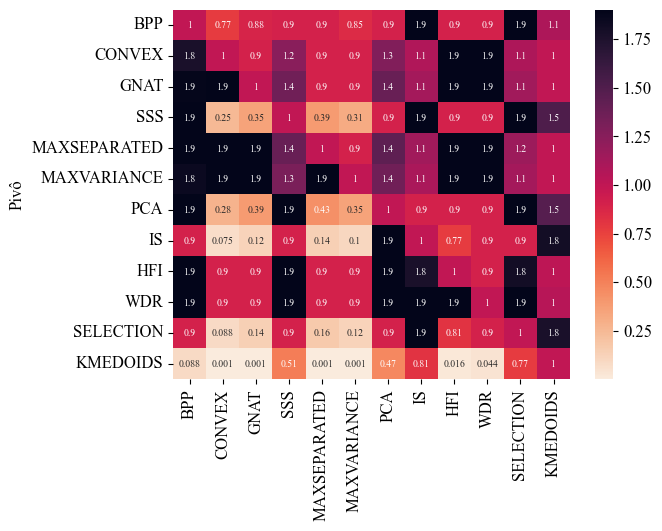

In [11]:
heatmap_p_value('./plan_pm_Calculos_de_distancia.csv', './p_values_pm.csv',
                outputPath = "/home/joaoleite/Documents/TCC/Figuras/Figuras_refeitas/", 
                outputName='pm')